# 5G Channel Coding and Rate-Matching: Polar vs. LDPC Codes

*"For block lengths of about 500, an IBM 7090 computer requires about 0.1 seconds per iteration to decode a block by probabilistic decoding scheme. Consequently, many hours of computation time are necessary to evaluate even a* $P(e)$ *in the order of* ${10^{-4}}$ *."* Robert G. Gallager, 1963 [7]

In this notebook, you will learn about the different coding schemes in 5G NR and how rate-matching works (cf. 3GPP TS 38.212 [3]).
The coding schemes are compared under different length/rate settings and for different decoders.

You will learn about the following components:

* 5G low-density parity-checks (LDPC) codes [7]. These codes support - without further segmentation - up to *k=8448* information bits per codeword [3] for a wide range of coderates.

* Polar codes [1] including CRC concatenation and rate-matching for 5G compliant en-/decoding is implemented for the Polar uplink control channel (UCI) [3]. Besides Polar codes, Reed-Muller (RM) codes and several decoders are available:
    - Successive cancellation (SC) decoding [1]
    - Successive cancellation list (SCL) decoding [2]
    - Hybrid SC / SCL decoding for enhanced throughput
    - Iterative belief propagation (BP) decoding [6]


Further, we will demonstrate the basic functionality of the Sionna forward error correction (FEC) module which also includes support for:

* Convolutional codes with non-recursive encoding and Viterbi/BCJR decoding

* Turbo codes and iterative BCJR decoding

* Interleaving and scrambling

For additional technical background we refer the interested reader to [4,5,8].

Please note that block segmentation is not implemented as it only concatenates multiple code blocks without increasing the effective codewords length (from decoder's perspective).

Some simulations in this notebook require severe simulation time, in particular if parameter sweeps are involved (e.g., different length comparisons).
Please keep in mind that each cell in this notebook already contains the pre-computed outputs and no new execution is required to understand the examples.

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [BER Performance of 5G Coding Schemes](#BER-Performance-of-5G-Coding-Schemes)
* [A Deeper Look into the Polar Code Module](#A-Deeper-Look-into-the-Polar-Code-Module)
* [Rate-matching](#Rate-Matching-and-Rate-Recovery)
* [Throughput and Decoding Complexity](#Throughput-and-Decoding-Complexity)
* [References](#References)

## GPU Configuration and Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time # for throughput measurements

In [2]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 2
Only GPU number 0 used.


In [3]:
# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Load the required Sionna components
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.fec.polar.utils import generate_5g_ranking, generate_rm_code
from sionna.fec.conv import ConvEncoder, ViterbiDecoder, BCJRDecoder
from sionna.fec.turbo import TurboEncoder, TurboDecoder
from sionna.utils import BinarySource, ebnodb2no
from sionna.utils.metrics import  count_block_errors
from sionna.channel import AWGN
from sionna.utils.plotting import PlotBER


## BER Performance of 5G Coding Schemes

Let us first focus on short length coding, e.g., for internet of things (IoT) and ultra-reliable low-latency communications (URLLC).
We aim to reproduce similar results as in [9] for the coding schemes supported by Sionna.

For a detailed explanation of the `PlotBER` class, we refer to the example notebook on [Bit-Interleaved Coded Modulation](https://nvlabs.github.io/sionna/examples/Bit_Interleaved_Coded_Modulation.html).

The Sionna API allows to pass an encoder object/layer to the decoder initialization for the 5G decoders. This means that the decoder is directly *associated* to a specific encoder and *knows* all relevant code parameters.
Please note that - of course - no data or information bits are exchanged between these two associated components. It just simplifies handling of the code parameters, in particular, if rate-matching is used.

Let us define the system model first. We use encoder and decoder as input parameter such that the model remains flexible w.r.t. the coding scheme.

In [4]:
class System_Model(tf.keras.Model):
    """System model for channel coding BER simulations.
    
    This model allows to simulate BERs over an AWGN channel with
    QAM modulation. Arbitrary FEC encoder/decoder layers can be used to 
    initialize the model.
    
    Parameters
    ----------
        k: int
            number of information bits per codeword.
        
        n: int 
            codeword length.
        
        num_bits_per_symbol: int
            number of bits per QAM symbol.
            
        encoder: Keras layer
            A Keras layer that encodes information bit tensors.
            
        decoder: Keras layer
            A Keras layer that decodes llr tensors.
            
        demapping_method: str
            A string denoting the demapping method. Can be either "app" or "maxlog".
            
        sim_esno: bool  
            A boolean defaults to False. If true, no rate-adjustment is done for the SNR calculation.
            
    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.
        
        ebno_db: float or tf.float
            A float defining the simulation SNR.
            
    Output
    ------
        (u, u_hat):
            Tuple:
        
        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.           

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.           
    """
    def __init__(self,
                 k,
                 n,
                 num_bits_per_symbol,                 
                 encoder,
                 decoder,
                 demapping_method="app",
                 sim_esno=False):

        super().__init__()
        
        # store values internally
        self.k = k
        self.n = n
        self.sim_esno = sim_esno # disable rate-adjustment for SNR calc
        
        # number of bit per QAM symbol
        self.num_bits_per_symbol = num_bits_per_symbol

        # init components
        self.source = BinarySource()
       
        # initialize mapper and demapper for constellation object
        self.constellation = Constellation("qam",
                                num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper(demapping_method,
                                 constellation=self.constellation)
        
        # the channel can be replaced by more sophisticated models
        self.channel = AWGN()

        # FEC encoder / decoder
        self.encoder = encoder
        self.decoder = decoder

    @tf.function() # enable graph mode for increased throughputs
    def call(self, batch_size, ebno_db):

        # calculate noise variance
        if self.sim_esno:
                no = ebnodb2no(ebno_db,
                       num_bits_per_symbol=1,
                       coderate=1)
        else: 
            no = ebnodb2no(ebno_db,
                           num_bits_per_symbol=self.num_bits_per_symbol,
                           coderate=self.k/self.n)            

        u = self.source([batch_size, self.k]) # generate random data
        c = self.encoder(u) # explicitly encode
        
        x = self.mapper(c) # map c to symbols x

        y = self.channel([x, no]) # transmit over AWGN channel

        llr_ch = self.demapper([y, no]) # demap y to LLRs

        u_hat = self.decoder(llr_ch) # run FEC decoder (incl. rate-recovery)

        return u, u_hat

 And let us define the codes to be simulated.

In [5]:
# code parameters
k = 64 # number of information bits per codeword
n = 128 # desired codeword length

# Create list of encoder/decoder pairs to be analyzed.
# This allows automated evaluation of the whole list later.
codes_under_test = []

# 5G LDPC codes with 20 BP iterations
enc = LDPC5GEncoder(k=k, n=n)
dec = LDPC5GDecoder(enc, num_iter=20)
name = "5G LDPC BP-20"
codes_under_test.append([enc, dec, name])

# Polar Codes (SC decoding)
enc = Polar5GEncoder(k=k, n=n)
dec = Polar5GDecoder(enc, dec_type="SC")
name = "5G Polar SC"
codes_under_test.append([enc, dec, name])

# Polar Codes (SCL decoding) with list size 8.
# The CRC is automatically added by the layer.
enc = Polar5GEncoder(k=k, n=n)
dec = Polar5GDecoder(enc, dec_type="SCL", list_size=8)
name = "5G Polar SCL-8+CRC"
codes_under_test.append([enc, dec, name])

### non-5G coding schemes

# RM codes with SCL decoding
f,_,_,_,_ = generate_rm_code(3,7) # equals k=64 and n=128 code
enc = PolarEncoder(f, n)
dec = PolarSCLDecoder(f, n, list_size=8)
name = "Reed Muller (RM) SCL-8"
codes_under_test.append([enc, dec, name])

# Conv. code with Viterbi decoding 
enc = ConvEncoder(rate=1/2, constraint_length=8)
dec = ViterbiDecoder(gen_poly=enc.gen_poly, method="soft_llr")
name = "Conv. Code Viterbi (constraint length 8)"
codes_under_test.append([enc, dec, name])

# Turbo. codes
enc = TurboEncoder(rate=1/2, constraint_length=4, terminate=False) # no termination used due to the rate loss
dec = TurboDecoder(enc, num_iter=8)
name = "Turbo Code (constraint length 4)"
codes_under_test.append([enc, dec, name])

*Remark*: some of the coding schemes are not 5G relevant, but are included in this comparison for the sake of completeness.

Generate a new BER plot figure to save and plot simulation results efficiently.

In [6]:
ber_plot128 = PlotBER(f"Performance of Short Length Codes (k={k}, n={n})")

And run the BER simulation for each code.


 Running: 5G LDPC BP-20
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6828e-01 | 8.6910e-01 |      107696 |      640000 |         8691 |       10000 |         2.3 |reached target bit errors
      0.5 | 1.2593e-01 | 6.9640e-01 |       80594 |      640000 |         6964 |       10000 |         0.1 |reached target bit errors
      1.0 | 8.6875e-02 | 5.0830e-01 |       55600 |      640000 |         5083 |       10000 |         0.1 |reached target bit errors
      1.5 | 5.0580e-02 | 3.0430e-01 |       32371 |      640000 |         3043 |       10000 |         0.1 |reached target bit errors
      2.0 | 2.4297e-02 | 1.4930e-01 |       15550 |      640000 |         1493 |       10000 |         0.1 |reached target bit errors
      2.5 | 1.0675e-02 | 6.6200e-02 |        6832 

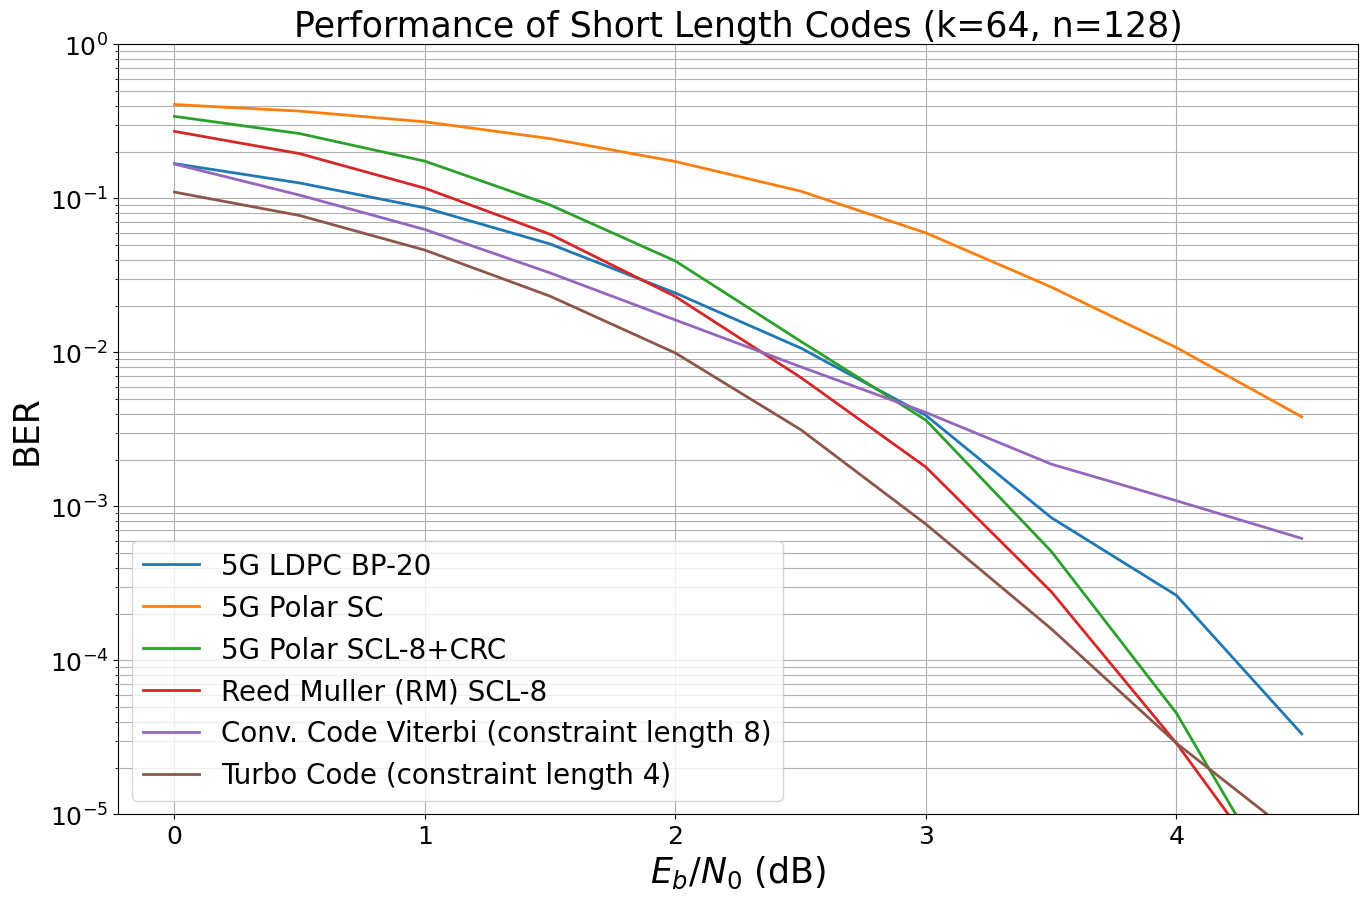

In [7]:
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 5, 0.5) # sim SNR range 

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])
    
    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot128.simulate(model, # the function have defined previously
                         ebno_dbs=ebno_db, # SNR to simulate
                         legend=code[2], # legend string for plotting
                         max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                         num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                         batch_size=10000, # batch-size per Monte Carlo run
                         soft_estimates=False, # the model returns hard-estimates
                         early_stop=True, # stop simulation if no error has been detected at current SNR point
                         show_fig=False, # we show the figure after all results are simulated
                         add_bler=True, # in case BLER is also interesting
                         forward_keyboard_interrupt=True); # should be True in a loop

# and show the figure
ber_plot128(ylim=(1e-5, 1), show_bler=False) # we set the ylim to 1e-5 as otherwise more extensive simulations would be required for accurate curves.


And let's also look at the block-error-rate.

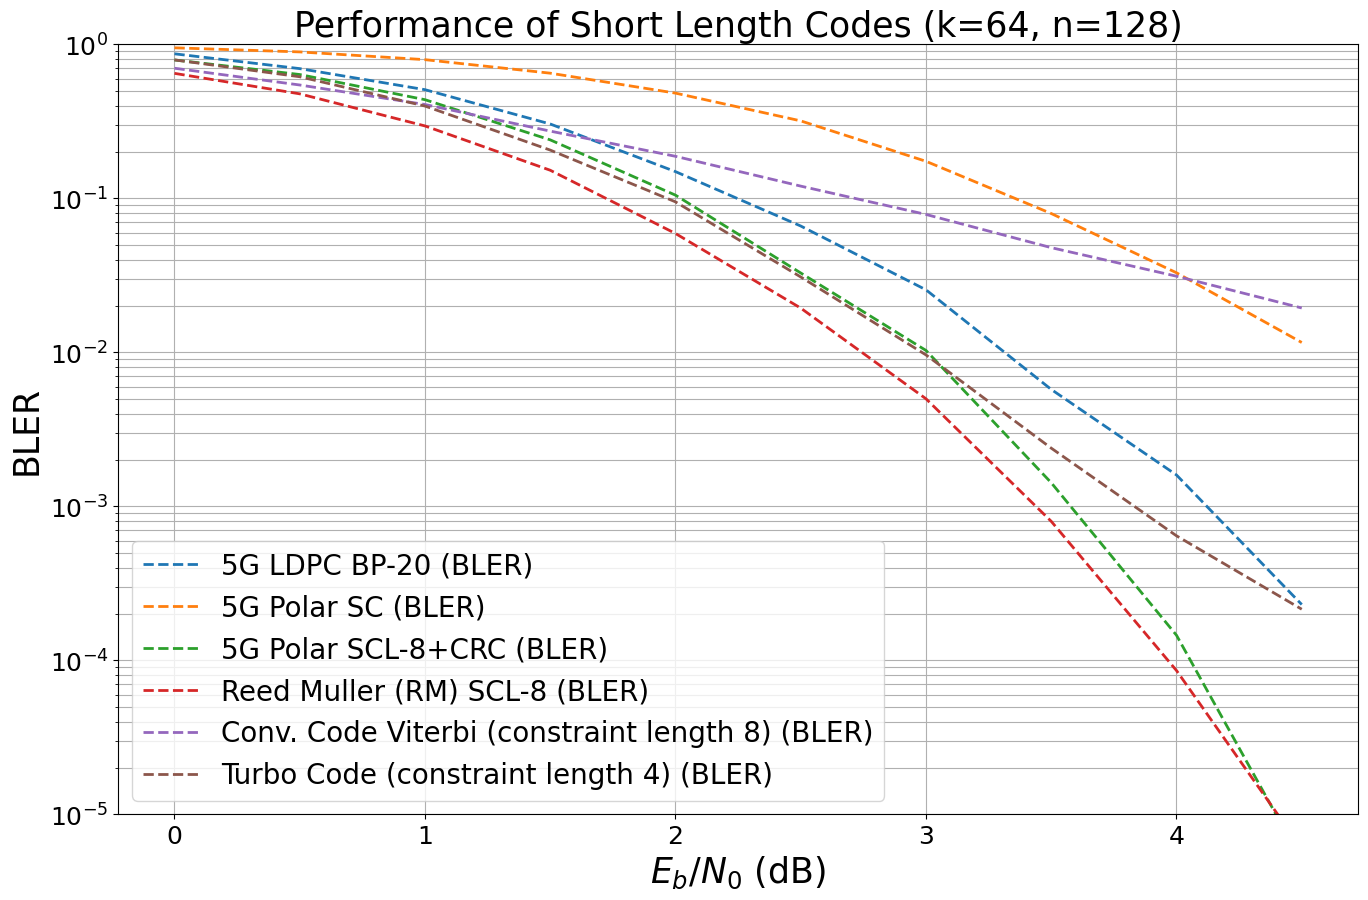

In [9]:
ber_plot128(ylim=(1e-5, 1), show_ber=False)

Please keep in mind that the decoding complexity differs significantly and should be also included in a fair comparison as shown in Section [Throughput and Decoding Complexity](#Throughput-and-Decoding-Complexity).

Now, let us have a look at the performance gains due to longer codewords. 
For this, we scale the length of the LDPC code and compare the results (same rate, same decoder, same channel).

In [8]:
# init new figure
ber_plot_ldpc = PlotBER(f"BER/BLER Performance of LDPC Codes @ Fixed Rate=0.5")

In [9]:
# code parameters to simulate
ns = [128, 256, 512, 1000, 2000, 4000, 8000, 16000]  # number of codeword bits per codeword
rate = 0.5 # fixed coderate

# create list of encoder/decoder pairs to be analyzed
codes_under_test = []

# 5G LDPC codes
for n in ns:
    k = int(rate*n) # calculate k for given n and rate
    enc = LDPC5GEncoder(k=k, n=n)
    dec = LDPC5GDecoder(enc, num_iter=20)
    name = f"5G LDPC BP-20 (n={n})"
    codes_under_test.append([enc, dec, name, k, n])


Running: 5G LDPC BP-20 (n=128)
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6914e-01 | 8.6600e-01 |       10825 |       64000 |          866 |        1000 |         1.0 |reached target block errors
     0.25 | 1.4652e-01 | 7.8400e-01 |        9377 |       64000 |          784 |        1000 |         0.1 |reached target block errors
      0.5 | 1.2748e-01 | 7.2800e-01 |        8159 |       64000 |          728 |        1000 |         0.1 |reached target block errors
     0.75 | 1.0242e-01 | 6.0000e-01 |        6555 |       64000 |          600 |        1000 |         0.1 |reached target block errors
      1.0 | 8.1711e-02 | 4.8800e-01 |       10459 |      128000 |          976 |        2000 |         0.1 |reached target block errors
     1.25 | 6.5227e-02 | 3.8400e-0

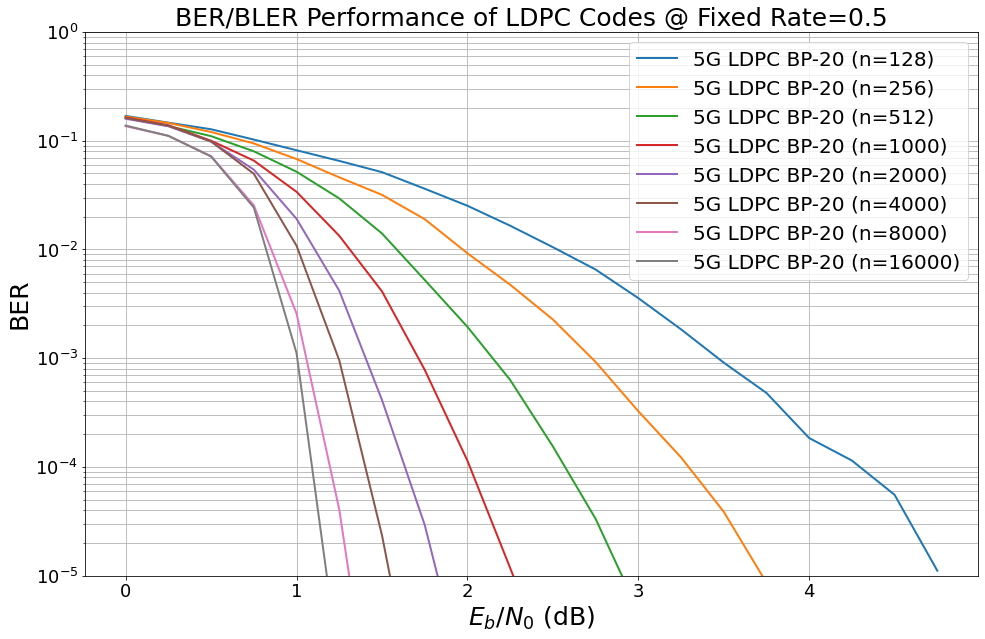

In [10]:
# and simulate the results
num_bits_per_symbol = 2 # QPSK

ebno_db = np.arange(0, 5, 0.25) # sim SNR range
# note that the waterfall for long codes can be steep and requires a fine
# SNR quantization

# run ber simulations for each case
for code in codes_under_test:
    print("Running: " + code[2])
    model = System_Model(k=code[3],
                         n=code[4],
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])
    
    # the first argument must be a callable (function) that yields u and u_hat 
    # for given batch_size and ebno
    # we fix the target number of BLOCK errors instead of the BER to 
    # ensure that same accurate results for each block lengths is simulated
    ber_plot_ldpc.simulate(model, # the function have defined previously
                           ebno_dbs=ebno_db,
                           legend=code[2],
                           max_mc_iter=100,
                           num_target_block_errors=500, # we fix the target block errors
                           batch_size=1000,
                           soft_estimates=False, 
                           early_stop=True,
                           show_fig=False,
                           forward_keyboard_interrupt=True); # should be True in a loop

# and show figure
ber_plot_ldpc(ylim=(1e-5, 1))

## A Deeper Look into the Polar Code Module

A Polar code can be defined by a set of `frozen bit` and `information bit` positions [1].
The package `sionna.fec.polar.utils` supports 5G-compliant Polar code design, but also Reed-Muller (RM) codes are available and can be used within the same encoder/decoder layer.
If required, rate-matching and CRC concatenation are handled by the class `sionna.fec.polar.Polar5GEncoder` and `sionna.fec.polar.Polar5GDecoder`, respectively.

Further, the following decoders are available:

* Successive cancellation (SC) decoding [1]
    * Fast and low-complexity
    * Sub-optimal error-rate performance
* Successive cancellation list (SCL) decoding [2]
    * Excellent error-rate performance
    * High-complexity
    * CRC-aided decoding possible
* Hybrid SCL decoder (combined SC and SCL decoder)
    * Pre-decode with SC and only apply SCL iff CRC fails
    * Excellent error-rate performance
    * Needs outer CRC (e.g., as done in 5G)
    * CPU-based implementation and, thus, no XLA support (+ increased decoding latency)
* Iterative belief propagation (BP) decoding [6]
    * Produces soft-output estimates
    * Sub-optimal error-rate performance

Let us now generate a new Polar code.

In [11]:
code_type = "5G" # try also "RM"

# Load the 5G compliant polar code
if code_type=="5G":    
    k = 32
    n = 64
    # load 5G compliant channel ranking [3]
    frozen_pos, info_pos = generate_5g_ranking(k,n)
    print("Generated Polar code of length n = {} and k = {}".format(n, k))
    print("Frozen codeword positions: ", frozen_pos)

# Alternatively Reed-Muller code design is also available
elif code_type=="RM":    
    r = 3
    m = 7
    frozen_pos, info_pos, n, k, d_min = generate_rm_code(r, m)
    print("Generated ({},{}) Reed-Muller code of length n = {} and k = {} with minimum distance d_min = {}".format(r, m, n, k, d_min))
    print("Frozen codeword positions: ", frozen_pos)

else:
    print("Code not found")

Generated Polar code of length n = 64 and k = 32
Frozen codeword positions:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 24 25 26
 32 33 34 35 36 37 40 48]


Now, we can initialize the encoder and a `BinarySource` to generate random Polar codewords.

In [12]:
# init polar encoder
encoder_polar = PolarEncoder(frozen_pos, n)

# init binary source to generate information bits
source = BinarySource()
# define a batch_size
batch_size = 1

# generate random info bits
u = source([batch_size, k])
# and encode
c = encoder_polar(u)

print("Information bits: ", u.numpy())
print("Polar encoded bits: ", c.numpy())

Information bits:  [[1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 1.]]
Polar encoded bits:  [[0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.
  1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.
  1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]


As can be seen, the length of the resulting code must be a power of 2. 
This brings us to the problem of rate-matching and we will now have a closer look how we can adapt the length of the code.

## Rate-Matching and Rate-Recovery

The general task of rate-matching is to enable flexibility of the code w.r.t. the codeword length $n$ and information bit input size $k$ and, thereby, the rate $r = \frac{k}{n}$. 
In modern communication standards such as 5G NR, these parameters can be adjusted on a bit-level granularity without - in a wider sense - redefining the (mother) code itself.
This is enabled by a powerful rate-matching and the corresponding rate-recovery block which will be explained in the following.


The principle idea is to select a mother code as close as possible to the desired properties from a set of possible mother codes.
For example for Polar codes, the codeword length must be a power of 2, i.e., $n = 32, 64, ..., 512, 1024$.
For LDPC codes the codeword length is more flexible (due to the different *lifting* factors), however, does not allow bit-wise granularity neither.
Afterwards, the bit-level granularity is provided by shortening, puncturing and repetitions.

To summarize, the rate-matching procedure consists of:

1. ) 5G NR defines multiple *mother* codes with similar properties (e.g., via base-graph lifting of LDPC code or sub-codes for Polar codes)
2. ) Puncturing, shortening and repetitions of bits to allow bit-level rate adjustments

The following figure summarizes the principle for the 5G NR Polar code uplink control channel (UCI). The Fig. is inspired by Fig. 6 in [9].

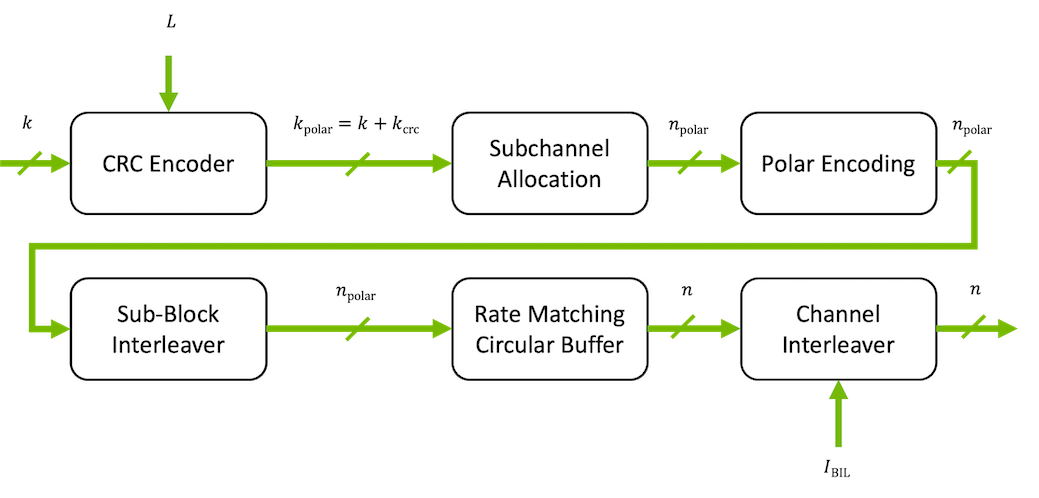


For bit-wise length adjustments, the following techniques are commonly used:

1. ) *Puncturing:* A ($k,n$) mother code is punctured by *not* transmitting $p$ punctured codeword bits. Thus, the rate increases to $r_{\text{pun}} = \frac{k}{n-p} > \frac{k}{n} \quad \forall p > 0$.
At the decoder these codeword bits are treated as erasure ($\ell_{\text{ch}} = 0$).

2. ) *Shortening:* A ($k,n$) mother code is shortened by setting $s$ information bits to a fixed (=known) value. Assuming systematic encoding, these $s$ positions are not transmitted leading to a new code of rate $r_{\text{short}} =  \frac{k-s}{n-s}<\frac{k}{n}$. At the decoder these codeword bits are treated as known values ($\ell_{\text{ch}} = \infty$).

3. ) *Repetitions* can be used to lower the effective rate.
For details we refer the interested reader to [11].



We will now simulate the performance of rate-matched 5G Polar codes for different lengths and rates. For this, we are interested in the required SNR to achieve a target BLER at $10^{-3}$.
Please note that this is a reproduction of the results from [Fig.13a, 4].

**Note**: This needs a bisection search as we usually simulate the BLER at fixed SNR and, thus, this is simulation takes some time. Please only execute the cell below if you have enough simulation capabilities.

In [13]:
# find the EsNo in dB to achieve target_bler
def find_threshold(model, # model to be tested 
                   batch_size=1000, 
                   max_batch_iter=10, # simulate cws up to batch_size * max_batch_iter
                   max_block_errors=100,  # number of errors before stop       
                   target_bler=1e-3): # target error rate to simulate (same as in[4])  
        """Bisection search to find required SNR to reach target SNR."""
        
        # bisection parameters        
        esno_db_min = -15 # smallest possible search SNR
        esno_db_max = 15 # largest possible search SNR
        esno_interval = (esno_db_max-esno_db_min)/4 # initial search interval size
        esno_db = 2*esno_interval + esno_db_min # current test SNR
        max_iters = 12 # number of iterations for bisection search

        # run bisection
        for i in range(max_iters):
            num_block_error = 0
            num_cws = 0
            for j in range(max_batch_iter):
                # run model and evaluate BLER
                u, u_hat = model(tf.constant(batch_size, tf.int32),
                                 tf.constant(esno_db, tf.float32))
                num_block_error += count_block_errors(u, u_hat) 
                num_cws += batch_size
                # early stop if target number of block errors is reached
                if num_block_error>max_block_errors:
                    break
            bler = num_block_error/num_cws
            # increase SNR if BLER was great than target
            # (larger SNR leads to decreases BLER)
            if bler>target_bler:
                esno_db += esno_interval        
            else: # and decrease SNR otherwise
                esno_db -= esno_interval 
            esno_interval = esno_interval/2
        
        # return final SNR after max_iters
        return esno_db


In [ ]:
# run simulations for multiple code parameters
num_bits_per_symbol = 2 # QPSK
# we sweep over multiple values for k and n
ks = np.array([12, 16, 32, 64, 128, 140, 210, 220, 256, 300, 400, 450, 460, 512, 800, 880, 940])
ns = np.array([160, 240, 480, 960])

# we use EsNo instead of EbNo to have the same results as in [4]
esno = np.zeros([len(ns), len(ks)])

for j,n in enumerate(ns):  
    for i,k in enumerate(ks):        
        if k<n: # only simulate if code parameters are feasible (i.e., r < 1)
            print(f"Finding threshold of k = {k}, n = {n}")
            
            # initialize new encoder / decoder pair
            enc = Polar5GEncoder(k=k, n=n)
            dec = Polar5GDecoder(enc, dec_type="SCL", list_size=8) 
            #build model
            model = System_Model(k=k,
                                 n=n,
                                 num_bits_per_symbol=num_bits_per_symbol,
                                 encoder=enc,
                                 decoder=dec,
                                 sim_esno=True) # no rate adjustment 
            # and find threshold via bisection search
            esno[j, i] = find_threshold(model)
            print("Found threshold at: ", esno[j, i])

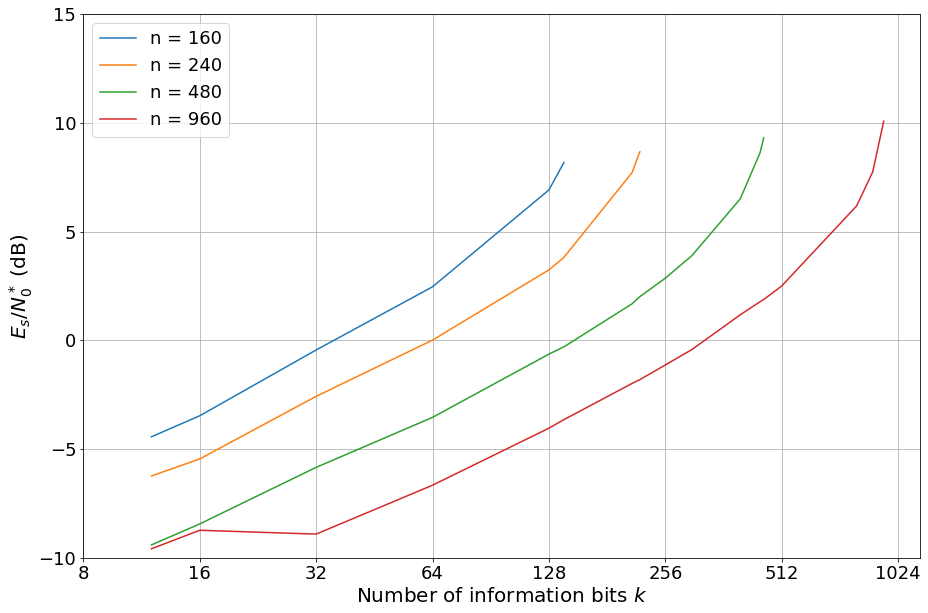

In [ ]:
# plot the results
leg_str = []
for j,n in enumerate(ns): 
    plt.plot(np.log2(ks[ks<n]), esno[j, ks<n])
    leg_str.append("n = {}".format(n))


# define labels manually
x_tick_labels = np.power(2, np.arange(3,11))
plt.xticks(ticks=np.arange(3,11),labels=x_tick_labels, fontsize=18)

# adjusted layout of figure
plt.grid("both")
plt.ylim([-10, 15])
plt.xlabel("Number of information bits $k$", fontsize=20)
plt.yticks(fontsize=18)
plt.ylabel("$E_s/N_0^*$ (dB)", fontsize=20)
plt.legend(leg_str, fontsize=18);
fig = plt.gcf() # get handle to current figure
fig.set_size_inches(15,10)

This figure equals [Fig. 13a, 4] with a few small exception for extreme low-rate codes. This can be explained by the fact that the 3 explicit parity-bits bits are not implemented, however, these bits are only relevant for for $12\leq k \leq20$.
It also explains the degraded performance of the n=960, k=16 code.

## Throughput and Decoding Complexity

In the last part of this notebook, you will compare the different computational complexity of the different codes and decoders.
In theory the complexity is given as:

- Successive cancellation list (SCL) decoding of Polar codes scales with $\mathcal{O}(L \cdot n \cdot \operatorname{log} n)$ (with $L=1$ for SC decoding)
- Iterative belief propagation (BP) decoding of LDPC codes scales with $\mathcal{O}(n)$.
However, in particular for short codes a complexity comparison should be supported by empirical results.

We want to emphasize that the results strongly depend on the exact implementation and may differ for different implementations/optimizations.
Implementing the SCL decoder in Tensorflow is a delicate task and requires several design trade-offs to enable a graph implementation which can lead to degraded throughput mainly caused by the missing *lazy copy-mechanism*. However,  - inspired by [10] - the SCL decoder layer supports `hybrid SC` decoding meaning that SC decoding is done first and a second stage SCL decoder operates as afterburner iff the outer CRC check fails. Please note that this modus uses *'tf.py_function'* (due to the control flow and the dynamic shape of the decoding graph) and, thus, does not support XLA compilation.

In [ ]:
def get_throughput(batch_size, ebno_dbs, model, repetitions=1):
    """ Simulate throughput in bit/s per ebno_dbs point.
    
    The results are average over `repetition` trials.
    
    Input
    -----
    batch_size: tf.int32
        Batch-size for evaluation.

    ebno_dbs: tf.float32
        A tensor containing SNR points to be evaluated.    
    
    model:
        Function or model that yields the transmitted bits `u` and the
        receiver's estimate `u_hat` for a given ``batch_size`` and
        ``ebno_db``.
        
    repetitions: int
        An integer defining how many trails of the throughput 
        simulation are averaged.
    
    """
    throughput = np.zeros_like(ebno_dbs)

    # call model once to be sure it is compile properly 
    # otherwise time to build graph is measured as well.
    u, u_hat = model(tf.constant(batch_size, tf.int32),    
                     tf.constant(0., tf.float32))

    for idx, ebno_db in enumerate(ebno_dbs):

        t_start = time.perf_counter()
        # average over multiple runs
        for _ in range(repetitions):
            u, u_hat = model(tf.constant(batch_size, tf.int32),
                             tf.constant(ebno_db, tf. float32))
        t_stop = time.perf_counter()
        # throughput in bit/s
        throughput[idx] = np.size(u.numpy())*repetitions / (t_stop - t_start)

    return throughput


In [ ]:
# plot throughput and ber together for ldpc codes
# and simulate the results
num_bits_per_symbol = 2 # QPSK

ebno_db = [5] # SNR to simulate
num_bits_per_batch = 5e6 # must be reduced in case of out-of-memory errors
num_repetitions = 20 # average throughput over multiple runs

# run throughput simulations for each code
throughput = np.zeros(len(codes_under_test))
code_length = np.zeros(len(codes_under_test))
for idx, code in enumerate(codes_under_test):
    print("Running: " + code[2])
    
    # save codeword length for plotting
    code_length[idx] = code[4] 
    
    # init new model for given encoder/decoder
    model = System_Model(k=code[3],
                         n=code[4],
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])
    
    # scale batch_size such that same number of bits is simulated for all codes
    batch_size = int(num_bits_per_batch / code[4])
    # and measure throughput of the model
    throughput[idx] = get_throughput(batch_size,
                                     ebno_db,
                                     model,
                                     repetitions=num_repetitions)

Running: 5G LDPC BP-20 (n=128)
Running: 5G LDPC BP-20 (n=256)
Running: 5G LDPC BP-20 (n=512)
Running: 5G LDPC BP-20 (n=1000)
Running: 5G LDPC BP-20 (n=2000)
Running: 5G LDPC BP-20 (n=4000)
Running: 5G LDPC BP-20 (n=8000)
Running: 5G LDPC BP-20 (n=16000)


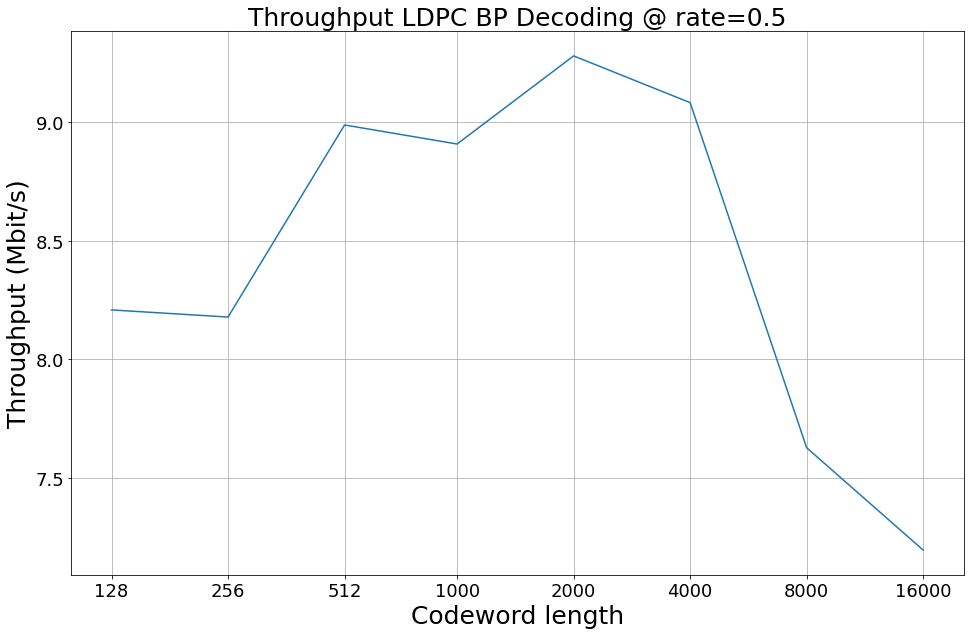

In [ ]:
# plot results
plt.figure(figsize=(16,10))

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.title("Throughput LDPC BP Decoding @ rate=0.5", fontsize=25)
plt.xlabel("Codeword length", fontsize=25)
plt.ylabel("Throughput (Mbit/s)", fontsize=25)
plt.grid(which="both")

# and plot results (logarithmic scale in x-dim)
x_tick_labels = code_length.astype(int)
plt.xticks(ticks=np.log2(code_length),labels=x_tick_labels, fontsize=18)
plt.plot(np.log2(code_length), throughput/1e6)


As expected the throughput of BP decoding is (relatively) constant as the complexity scales linearly with $\mathcal{O}(n)$ and, thus, the complexity *per* decoded bit remains constant.
It is instructive to realize that the above plot is in the log-domain for the x-axis.

Let us have a look at what happens for different SNR values.

In [ ]:
# --- LDPC ---
n = 1000
k = 500
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder)

# init a new model
model = System_Model(k=k,
                     n=n,
                     num_bits_per_symbol=num_bits_per_symbol,
                     encoder=encoder,
                     decoder=decoder)

# run throughput tests at 2 dB and 5 dB
ebno_db = [2, 5]
batch_size = 10000
throughput = get_throughput(batch_size,
                            ebno_db, # snr point
                            model,
                            repetitions=num_repetitions)

# and print the results
for idx, snr_db in enumerate(ebno_db):
    print(f"Throughput @ {snr_db:.1f} dB: {throughput[idx]/1e6:.2f} Mbit/s")

Throughput @ 2.0 dB: 10.91 Mbit/s
Throughput @ 5.0 dB: 10.90 Mbit/s


For most Sionna decoders the throughput is not SNR dependent as early stopping of individual samples within a batch is difficult to realize.

However, the `hybrid SCL` decoder uses an internal NumPy SCL decoder only if the SC decoder failed similar to [10].
We will now benchmark this decoder for different SNR values.

In [ ]:
# --- Polar ---
n = 256
k = 128
encoder = Polar5GEncoder(k, n)
decoder = Polar5GDecoder(encoder, "hybSCL")

# init a new model
model = System_Model(k=k,
                     n=n,
                     num_bits_per_symbol=num_bits_per_symbol,
                     encoder=encoder,
                     decoder=decoder)

ebno_db = np.arange(0, 5, 0.5) # EbNo to evaluate
batch_size = 1000
throughput = get_throughput(batch_size,
                            ebno_db, # snr point
                            model,
                            repetitions=num_repetitions)

# and print the results
for idx, snr_db in enumerate(ebno_db):
    print(f"Throughput @ {snr_db:.1f} dB: {throughput[idx]/1e6:.3f} Mbit/s")

Throughput @ 0.0 dB: 0.016 Mbit/s
Throughput @ 0.5 dB: 0.017 Mbit/s
Throughput @ 1.0 dB: 0.020 Mbit/s
Throughput @ 1.5 dB: 0.029 Mbit/s
Throughput @ 2.0 dB: 0.047 Mbit/s
Throughput @ 2.5 dB: 0.100 Mbit/s
Throughput @ 3.0 dB: 0.236 Mbit/s
Throughput @ 3.5 dB: 0.893 Mbit/s
Throughput @ 4.0 dB: 1.294 Mbit/s
Throughput @ 4.5 dB: 1.469 Mbit/s


We can overlay the throughput with the BLER of the SC decoder. 
This can be intuitively explained by the fact that he `hybrid SCL` decoder consists of two decoding stages:

- SC decoding for all received codewords.
- SCL decoding *iff* the CRC does not hold, i.e., SC decoding did not yield the correct codeword.

Thus, the throughput directly depends on the BLER of the internal SC decoder.

In [ ]:
ber_plot_polar = PlotBER("Polar SC/SCL Decoding")

ber_plot_polar.simulate(model, # the function have defined previously
                        ebno_dbs=ebno_db,
                        legend="hybrid SCL decoding",
                        max_mc_iter=100,
                        num_target_block_errors=100, # we fix the target bler
                        batch_size=1000,
                        soft_estimates=False, 
                        early_stop=True,
                        add_ber=False,
                        add_bler=True,
                        show_fig=False,
                        forward_keyboard_interrupt=False);

# and add SC decoding
decoder2 = Polar5GDecoder(encoder, "SC")

model = System_Model(k=k,
                     n=n,
                     num_bits_per_symbol=num_bits_per_symbol,
                     encoder=encoder,
                     decoder=decoder2)

ber_plot_polar.simulate(model, # the function have defined previously
                        ebno_dbs=ebno_db,
                        legend="SC decoding",
                        max_mc_iter=100,
                        num_target_block_errors=100, # we fix the target bler
                        batch_size=1000,
                        soft_estimates=False, 
                        early_stop=True,
                        add_ber=False, # we only focus on BLER
                        add_bler=True,
                        show_fig=False,
                        forward_keyboard_interrupt=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.3807e-01 | 8.3300e-01 |       43273 |      128000 |          833 |        1000 |         7.8 |reached target block errors
      0.5 | 2.2667e-01 | 6.0800e-01 |       29014 |      128000 |          608 |        1000 |         7.4 |reached target block errors
      1.0 | 1.1982e-01 | 3.4100e-01 |       15337 |      128000 |          341 |        1000 |         6.3 |reached target block errors
      1.5 | 4.4477e-02 | 1.3400e-01 |        5693 |      128000 |          134 |        1000 |         4.6 |reached target block errors
      2.0 | 9.6211e-03 | 3.2000e-02 |        4926 |      512000 |          128 |        4000 |        10.4 |reached target block errors
      2.5 | 1.2563e-03 | 4.7619e-03 |        3377 |     2688000 |

Let us visualize the results.

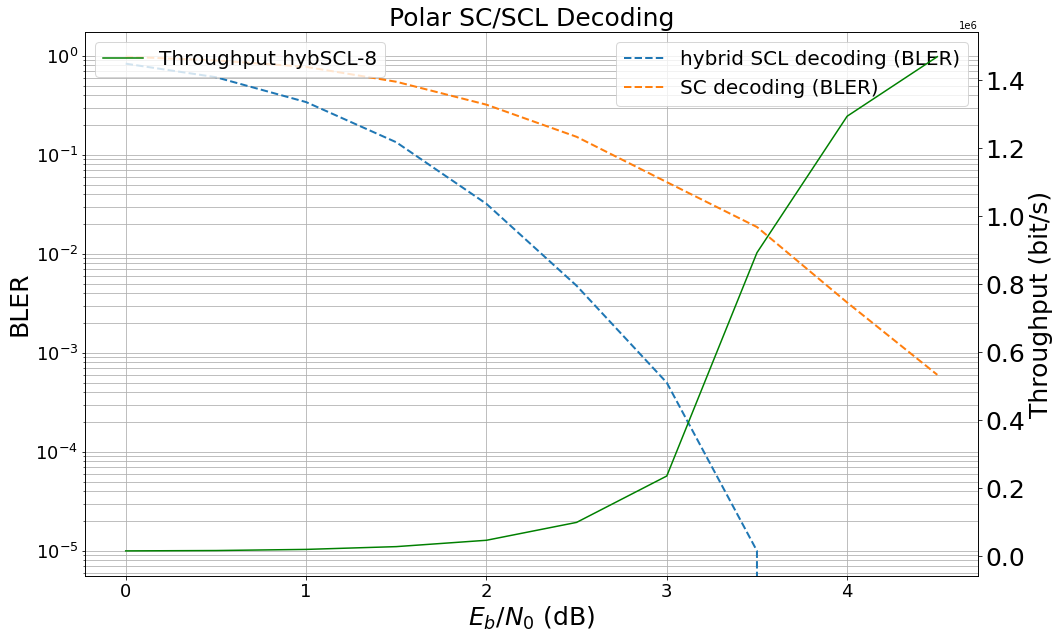

In [ ]:
ber_plot_polar()
ax2 = plt.gca().twinx()  # new axis 
ax2.plot(ebno_db, throughput, 'g', label="Throughput hybSCL-8")
ax2.legend(fontsize=20)
ax2.set_ylabel("Throughput (bit/s)", fontsize=25);
ax2.tick_params(labelsize=25)

You can also try:

- Analyze different rates
- What happens for different batch-sizes? Can you explain what happens?
- What happens for higher order modulation. Why is the complexity increased?

## References

[1] E. Arikan, "Channel polarization: A method for constructing capacity-achieving codes for symmetric binary-input memoryless channels," IEEE Transactions on Information Theory, 2009.

[2] Ido Tal and Alexander Vardy, "List Decoding of Polar Codes." IEEE Transactions on Information Theory, 2015.

[3] ETSI 3GPP TS 38.212 "5G NR Multiplexing and channel coding", v.16.5.0, 2021-03.

[4] V. Bioglio, C. Condo, I. Land, "Design of Polar Codes in 5G New Radio." IEEE Communications Surveys & Tutorials, 2020.

[5] D. Hui, S. Sandberg, Y. Blankenship, M. Andersson, L. Grosjean "Channel coding in 5G new radio: A Tutorial Overview and Performance Comparison with 4G LTE." IEEE Vehicular Technology Magazine, 2018.

[6] E. Arikan, “A Performance Comparison of Polar Codes and Reed-Muller Codes,” IEEE Commun. Lett., vol. 12, no. 6, pp. 447–449, Jun. 2008.

[7] R. G. Gallager, Low-Density Parity-Check Codes, M.I.T. Press Classic Series, Cambridge MA, 1963.

[8] T. Richardson and S. Kudekar. "Design of low-density parity check codes for 5G new radio," IEEE Communications Magazine 56.3, 2018.

[9] G. Liva, L. Gaudio, T. Ninacs, T. Jerkovits, "Code design for short blocks: A survey," arXiv preprint arXiv:1610.00873, 2016.

[10] S. Cammerer, B. Leible, M. Stahl, J. Hoydis, and S ten Brink, "Combining Belief Propagation and Successive Cancellation List Decoding of Polar Codes on a GPU Platform," IEEE ICASSP, 2017.

[11] V. Bioglio, F. Gabry, I. Land, "Low-complexity puncturing and shortening of polar codes," IEEE Wireless Communications and Networking Conference Workshops (WCNCW), 2017.